# Imports and Functions

In [1]:
from sunlab.environment.base.cpu import *
from sunlab.environment.base.extras import *
from sunlab.globals import FILES
from sunlab.sunflow import *

In [10]:
def proximity_to(dest_arr, src, R=0.15):
    assert src.shape[-1] == dest_arr.shape[-1], f"Shape Mismatch! {src.shape}, {dest_arr.shape}"
    arrs = []
    for row in dest_arr:
        if np.linalg.norm(src-row) < R:
            arrs.append(row)
    return np.array(arrs)

def dotProduct(a,b, norm=False, axis=-1):
    if norm:
        return np.sum(a*b,axis=axis)/(np.linalg.norm(a,axis=axis)*np.linalg.norm(b,axis=axis))
    return np.sum(a*b, axis=axis)

def DistanceCovariance(model, mfv_dataset, labels=None, shuffle=False, silent=False):
    """# Distance Covariance
    Compute the distance in the MFS and MLS
    - mfv_dataset: (N,13)
    - labels: (N,...) ?"""
    from numpy import vstack, array
    from numpy.linalg import norm
    from tqdm.auto import tqdm
    assert mfv_dataset.shape[1] == 13
    if labels is None:
        neighborhood_labels = None
    else:
        assert labels.shape[0] == mfv_dataset.shape[0]
        neighborhood_labels = []
    neighborhood_distances = []
    progress = tqdm
    if silent:
        progress = lambda x: x
    for cell_index in progress(range(mfv_dataset.shape[0])):
        source_cell = mfv_dataset[[cell_index],:]
        destination_cells = vstack([mfv_dataset[:cell_index,:], mfv_dataset[(cell_index+1):,:]])
        mfv_distance = norm((destination_cells - source_cell), axis=-1)
        mlv_distance = norm((model.encoder(destination_cells)-model.encoder(source_cell)), axis=-1)
        v_distances = list(zip(mfv_distance, mlv_distance))
        if labels is not None:
            neighborhood_labels.extend([labels[cell_index,...]] * len(v_distances))
        for distance in v_distances:
            neighborhood_distances.append(distance)
    neighborhood_distances = array(neighborhood_distances)
    if labels is not None:
        neighborhood_labels = array(neighborhood_labels)
    if shuffle:
        from numpy.random import permutation as permute
        permutation = permute(neighborhood_distances.shape[0])
        neighborhood_distances = neighborhood_distances[permutation,...]
        if labels is not None:
            neighborhood_labels = neighborhood_labels[permutation,...]
    return neighborhood_distances, neighborhood_labels

def AngleCovariance(model, mfv_dataset, labels=None, filter_R=0.15, shuffle=False, silent=False):
    """# Angular Covariance
    Compute the angular mapping in the MFS and MLS
    - mfv_dataset: (N,13)
    - labels: (N,...) ?"""
    from numpy import vstack, array, ones_like
    from numpy.linalg import norm
    from tqdm.auto import tqdm
    assert mfv_dataset.shape[1] == 13
    if labels is None:
        neighborhood_labels = None
    else:
        assert labels.shape[0] == mfv_dataset.shape[0]
        neighborhood_labels = []
    neighborhood_dot_products = []
    progress = tqdm
    if silent:
        progress = lambda x: x
    for cell_index in progress(range(mfv_dataset.shape[0])):
        source_cell = mfv_dataset[[cell_index],:]
        for middle_cell_index in range(cell_index+1,mfv_dataset.shape[0]):
            middle_cell = mfv_dataset[[middle_cell_index],:]
            if norm((middle_cell - source_cell)) > filter_R:
                continue
            middle_cell_mlv = model.encoder(middle_cell)
            destination_cells = mfv_dataset[(middle_cell_index+1):,:]
            destination_cells = proximity_to(destination_cells, middle_cell, R=filter_R)
            if destination_cells.shape[0] == 0:
                continue
            comparison_vector = ones_like(destination_cells) * (middle_cell - source_cell)
            source_cell_stacks_mlv = model.encoder(ones_like(destination_cells) * source_cell).numpy()
            destination_cells_mlv = model.encoder(destination_cells).numpy()
            mfv_dot = dotProduct(comparison_vector, (destination_cells - middle_cell), axis=-1, norm=True)
            mlv_dot = dotProduct(middle_cell_mlv - source_cell_stacks_mlv,
                                 destination_cells_mlv - middle_cell_mlv, axis=-1, norm=True)
            v_dot_products = list(zip(mfv_dot, mlv_dot))
            if labels is not None:
                neighborhood_labels.extend([labels[cell_index,...]] * len(v_dot_products))
            for dot_product in v_dot_products:
                neighborhood_dot_products.append(dot_product)
    neighborhood_dot_products = array(neighborhood_dot_products)
    if labels is not None:
        neighborhood_labels = array(neighborhood_labels)
    if shuffle:
        from numpy.random import permutation as permute
        permutation = permute(neighborhood_dot_products.shape[0])
        neighborhood_dot_products = neighborhood_dot_products[permutation,...]
        if labels is not None:
            neighborhood_labels = neighborhood_labels[permutation,...]
    return np.arccos(neighborhood_dot_products), neighborhood_labels

# Setup

In [2]:
sampled_data = np.load_dat(FILES['FIGURES']['3']['SAMPLED_DATASET'])
sampled_dataset = sampled_data['dataset']
sampled_labels = sampled_data['labels']

In [4]:
model = load_aae(FILES['PRETRAINED_MODEL_DIR'], MaxAbsScaler)

In [16]:
distances, di_labels = DistanceCovariance(model, sampled_dataset, sampled_labels, shuffle=True)

  0%|          | 0/320 [00:00<?, ?it/s]

In [18]:
dots, do_labels = AngleCovariance(model, sampled_dataset, sampled_labels, shuffle=True)

  0%|          | 0/320 [00:00<?, ?it/s]

/tmp/4098278.1.sun-gpu.q/ipykernel_11491/659413713.py:102: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(neighborhood_dot_products), neighborhood_labels


# Runtime Parameters

In [14]:
SAVE_EXTRAS = False

In [13]:
g_Base = lambda *args: DIR_ROOT + "Figures/Invasion/"

# Plots

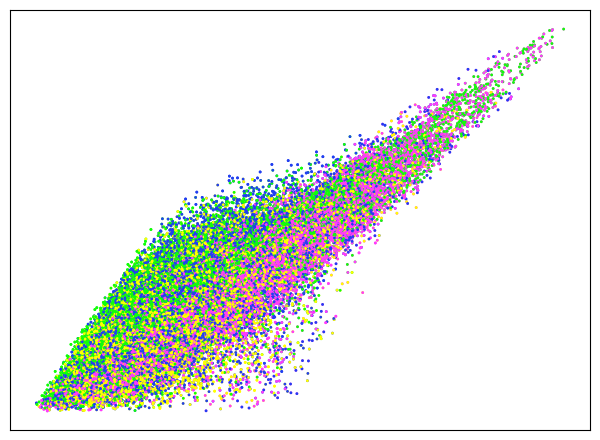

In [17]:
plt.scatter2d(distances, s=1, c=di_labels, cmap=Pmap)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Spheroid/Sampled/Distance/Colored")

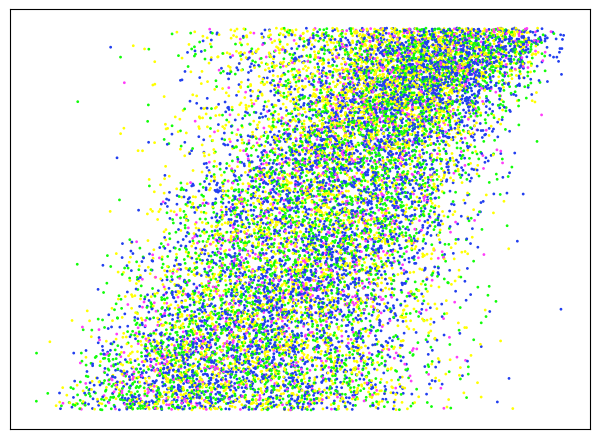

In [19]:
plt.scatter2d(dots, s=1, c=do_labels, cmap=Pmap)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Spheroid/Sampled/Angle/Colored")

# END